In [5]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [6]:
# Configuration
OBSERVATION_START = '2023-01-01'  # Arbitrary start date for analysis
OBSERVATION_END = '2024-01-01'    # 1-year observation window
HARDCODED_CHURN_THRESHOLD = 7     # Default threshold if data-driven fails

In [7]:
def load_instacart_data(orders_path, order_products_path):
    """
    Load and merge Instacart datasets
    orders.csv: Order metadata
    order_products.csv: Product-level details per order
    """
    # Load order metadata
    orders = pd.read_csv(orders_path)
    
    # Convert eval_set to categorical and filter to historical orders
    orders['eval_set'] = orders['eval_set'].astype('category')
    orders = orders[orders['eval_set'] == 'prior']  # Use historical orders only
    
    # Load product-level order details
    order_products = pd.read_csv(order_products_path)
    
    # Merge order metadata with product details
    transactions = orders.merge(order_products, on='order_id')
    
    # Create transaction date PER USER
    base_date = pd.to_datetime(OBSERVATION_START)
    
    # Ensure chronological order
    transactions = transactions.sort_values(['user_id', 'order_number'])
    
    # Calculate cumulative days PER USER
    transactions['cumulative_days'] = transactions.groupby('user_id')['days_since_prior_order'].cumsum().fillna(0)
    
    transactions['order_date'] = base_date + pd.to_timedelta(
        transactions['cumulative_days'], 
        unit='d'
    )
    
    return transactions

def preprocess_transactions(transactions):
    """Prepare transaction data for survival analysis"""
    # Filter to observation window
    mask = (transactions['order_date'] >= OBSERVATION_START) & \
           (transactions['order_date'] <= OBSERVATION_END)
    window_transactions = transactions[mask].copy()
    
    # Aggregate customer-level metrics
    customer_activity = window_transactions.groupby('user_id').agg(
        first_transaction=('order_date', 'min'),
        last_transaction=('order_date', 'max'),
        transaction_count=('order_id', 'nunique')
    ).reset_index()
    
    # Calculate gaps between orders
    window_transactions = window_transactions.sort_values(['user_id', 'order_date'])
    window_transactions['prev_date'] = window_transactions.groupby('user_id')['order_date'].shift()
    window_transactions['gap'] = (window_transactions['order_date'] - window_transactions['prev_date']).dt.days
    
    # Find maximum gap per customer
    max_gaps = window_transactions.groupby('user_id')['gap'].max().reset_index()
    customer_activity = customer_activity.merge(max_gaps, on='user_id', how='left')
    
    return customer_activity.fillna(0)  # Fill NaNs for single-transaction customers

def calculate_churn_metrics(customer_activity, churn_threshold):
    """Calculate survival analysis metrics with churn threshold"""
    # Calculate days inactive at observation end
    customer_activity['days_inactive'] = (
        pd.to_datetime(OBSERVATION_END) - customer_activity['last_transaction']
    ).dt.days
    
    # Determine churn status
    customer_activity['churned'] = (
        customer_activity['days_inactive'] >= churn_threshold
    ).astype(int)
    
    # Calculate observation period duration
    customer_activity['T'] = customer_activity.apply(
        lambda row: (min(row['last_transaction'], pd.to_datetime(OBSERVATION_END)) - row['first_transaction']).days,
        axis=1
    )
    
    return customer_activity

Data-driven churn threshold: 30 days


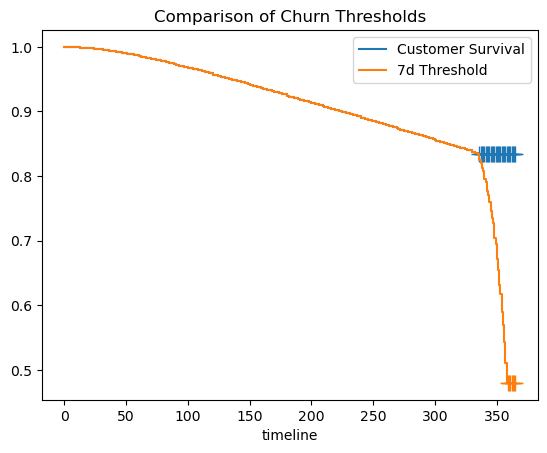

In [9]:
# --- Main Execution ---
if __name__ == "__main__":
    # Step 1: Load Instacart data
    transactions = load_instacart_data(
        orders_path='orders.csv', 
        order_products_path='order_products__prior.csv'
    )
    
    # Step 2: Preprocess transactions
    customer_activity = preprocess_transactions(transactions)
    
    # Step 3: Calculate data-driven churn threshold
    # Use 90th percentile of maximum gaps between orders
    gap_percentiles = customer_activity['gap'].quantile([0.75, 0.85, 0.90, 0.95])
    data_driven_threshold = int(gap_percentiles[0.90])
    print(f"Data-driven churn threshold: {data_driven_threshold} days")
    
    # # Step 4: Apply churn definition
    # survival_data = calculate_churn_metrics(
    #     customer_activity, 
    #     churn_threshold=data_driven_threshold
    # )
    
    # # Step 5: Fit Kaplan-Meier model
    # kmf = KaplanMeierFitter()
    # kmf.fit(
    #     durations=survival_data['T'],
    #     event_observed=survival_data['churned'],
    #     label='Customer Survival'
    # )
    
    # # Step 6: Plot survival curve
    # plt.figure(figsize=(12, 6))
    # kmf.plot_survival_function()
    # plt.title(f'Customer Alive Probability (Instacart Data)\nChurn Threshold: {data_driven_threshold} days')
    # plt.xlabel('Days Since First Transaction')
    # plt.ylabel('Probability of Being Alive')
    # plt.axvline(data_driven_threshold, color='r', linestyle='--', alpha=0.3, label='Churn Threshold')
    # plt.grid(True)
    # plt.legend()
    # plt.ylim(0, 1)
    # plt.tight_layout()
    # plt.show()
    
    # Optional: Hardcoded threshold comparison
    hardcoded_data = calculate_churn_metrics(
        customer_activity,
        churn_threshold=HARDCODED_CHURN_THRESHOLD
    )
    kmf_hardcoded = KaplanMeierFitter()
    kmf_hardcoded.fit(
        durations=hardcoded_data['T'],
        event_observed=hardcoded_data['churned'],
        label=f'{HARDCODED_CHURN_THRESHOLD}d Threshold'
    )
    
    ax = kmf.plot_survival_function(show_censors=True, ci_show=False)
    kmf_hardcoded.plot_survival_function(ax=ax, show_censors=True, ci_show=False)
    plt.title('Comparison of Churn Thresholds')
    plt.legend()
    plt.show()